## Project Code (Part 1) : Scrape Data with BeautifulSoup and Zillow API

Our final project topic is to analyze the most important factors of the price of renting house in Boston and do some recommandations. As we want to get most recent data, we decide to scrape the renting house information. 

At first, we want to use the API of Zillow.com, but we found that if we want to use this API, we need to input the address. The biggest problem is that it is almost impossible for use to use all the address of Boston to test the API( To use API, we need to register with e-mail first, and we can only make 1000 request per day). Thus, we need to scrape the address somewhere else. Fortunately, Katherine told us that we can scraoe the address from Trulia.com and use these address to request the API of Zillow.com.

For the reasons above, I use beautifulsoup package first to scrape the data from Trulia.com. I get the basic informations of about 7500 houses, like address, zipcode, price and the url of house(used to scrape more data of the houses). Then I use the addresses and zipcode as the input of Zillow API to request for more informations(number of bedrooms, bathrooms, hometype, latitude, longitude, id, etc). As some address are invalid in Zillow API, I get about 5700 houses' information. Then I store the data in csv file.

In the Ipython notebook, I still do some clustering demo. As I haven't scrape all the needed information of houses, I will do clustering in later works.


In [1]:
from bs4 import BeautifulSoup
import sys
import time
import os
import requests
import json
import pandas as pd
from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture

%matplotlib inline

In [ ]:
'''
    Scrape the data from Trulia.com
    We Scrape house renting informations like Street Address, Zipcode, Price, Bedrooms and Bathroom.
    However, There is a little problem about the bedrooms and bathroom information. 
    After we get the information from Trulia.com, we will use them to get more information from zillow.com
    (including the correct bedrooms and bathrooms information)
    We store the data in a dictionary
'''

base_url = 'https://www.trulia.com/for_rent/Boston,MA/'
url = 'https://www.trulia.com/for_rent/Boston,MA/'
dic = {'street':[],'zipcode':[],'price':[],'bedrooms':[],'bathrooms':[],'house_url':[]}
flag = 1
while(True):
    response = requests.get(url)
    print('page '+ str(flag)+' has been successfully loaded...')
    html = response.text.encode('utf-8')
    soup = BeautifulSoup(html,'lxml')
#     print(soup)
    addresses = soup.findAll('div',{'class':"cardBody mbl backgroundBasic bbm "})
    for address in addresses:
        if(address.find('h2',{'itemprop':'streetAddress'})):
            house_add = address.find('h2',{'itemprop':'streetAddress'}).text
        else:
            house_add = address.find('span',{'itemprop':'streetAddress'}).text
        house_add += ' ' 
        house_add += address.find('span',{'itemprop':'addressLocality'}).text
        house_add += ', '
        house_add += address.find('span',{'itemprop':'addressRegion'}).text
        dic['street'].append(house_add)
#         print(type(address.find('span',{'itemprop':'postalCode'}).text))
        dic['zipcode'].append(address.find('span',{'itemprop':'postalCode'}).text)
        dic['price'].append(address.find('span',{'class':'typeEmphasize'}).text)
#         print(address.findAll('small'))
        dic['bedrooms'].append(address.findAll('small')[1].text)
        dic['bathrooms'].append(address.findAll('small')[2].text)
        dic['house_url'].append(address.find('a',{'class':'primaryLink pdpLink activeLink'})['href'])
#     next_p = soup.find('div',{'class':'col cols4 lastCol'})
#     print(next_p)
    if soup.find('button',{'disabled':'disabled'}):
        break
    else:
        flag += 1
        url = base_url + str(flag) +'_p'
    time.sleep(0.04)

page 1 has been successfully loaded
page 2 has been successfully loaded
page 3 has been successfully loaded
page 4 has been successfully loaded
page 5 has been successfully loaded
page 6 has been successfully loaded
page 7 has been successfully loaded


In [6]:
'''
    put the data into a dataframe and create a csv file for it
'''
df = pd.DataFrame(data=dic)
df = df[['street','zipcode','price','bedrooms','bathrooms','house_url']]
df.to_csv('data_for_house_125.csv')

In [2]:
'''
    Get house info from the csv file
'''

df_address = pd.read_csv('data_for_house_125.csv',index_col=0)
address = df_address['street'].tolist()
zipcode = df_address['zipcode'].tolist()
price = df_address['price'].tolist()
house_url = df_address['house_url'].tolist()
zip_str = []
for z in zipcode:
    z = '0' + str(z)
    zip_str.append(z)

**Zillow API keys **

Each key can make 1000 request per day

X1-ZWz19hshbsoavf_40oka

X1-ZWz1fiu1mxaosr_6v82r

X1-ZWz19hon7msgln_6r0dc

In [41]:
'''Test Code
'''
# zillow_data = ZillowWrapper("X1-ZWz1fiu1mxaosr_6v82r")
deep_search_response = zillow_data.get_deep_search_results('99 Kneeland St, Boston, MA',zip_str[14].split('.')[0])
result=GetDeepSearchResults(deep_search_response)
print(result.longitude)
print(result.latitude)
print(result.bedrooms)
print(result.bathrooms)
print(result.zillow_id)
print(result.home_type)

In [18]:
'''
    Use the street and zipcode info from 'data_for_house.csv' 
    Use Zillow API to get more information about the house(Latitude, Longitude, Bedrooms, Bathrooms and Home_type)
    Store all these data in dct
    WARNING: Zillow API only allows us make 1000 requests per day(maybe more)
'''
dct = {'Street':[],'Zipcode':[],'Price':[],'Bedrooms':[],'Bathrooms':[],'Longitude':[],'Latitude':[],'Zillow_Id':[],'Home_type':[],'House_url':[]}
zillow_data = ZillowWrapper("X1-ZWz19hon7msgln_6r0dc")
for i in range(7000,len(address)):
    try:
        deep_search_response = zillow_data.get_deep_search_results(address[i],zip_str[i].split('.')[0])
        result=GetDeepSearchResults(deep_search_response)
        dct['Street'].append(address[i])
        dct['Zipcode'].append(zipcode[i])
        dct['Price'].append(price[i])
        dct['House_url'].append(house_url[i])
        dct['Longitude'].append(result.longitude)
        dct['Latitude'].append(result.latitude)
        dct['Bedrooms'].append(result.bedrooms)
        dct['Bathrooms'].append(result.bathrooms)
        dct['Zillow_Id'].append(result.zillow_id)
        dct['Home_type'].append(result.home_type)
    except:
        pass

In [27]:
'''
    Create a new csv file for more detialed information about the houses
'''

df_house_info = pd.DataFrame(data=dct)
df_house_info = df_house_info[df_house_info.Bedrooms != '0']
df_house_info = df_house_info[['Street','Zipcode','Price','Bedrooms','Bathrooms','Home_type','Longitude','Latitude','House_url']]
df_house_info.to_csv('new_house_info(7000-)_125.csv')

In [28]:
"""Store all the filenames in a list
"""
filenames= []
filenames.append('new_house_info(0-1000)_125.csv')
filenames.append('new_house_info(1000-2000)_125.csv')
filenames.append('new_house_info(2000-3000)_125.csv')
filenames.append('new_house_info(3000-4000)_125.csv')
filenames.append('new_house_info(4000-5000)_125.csv')
filenames.append('new_house_info(5000-6000)_125.csv')
filenames.append('new_house_info(6000-7000)_125.csv')
filenames.append('new_house_info(7000-)_125.csv')

In [30]:
df_list = []
for i in range(len(filenames)):
    df_tmp = pd.read_csv(filenames[i],index_col=0)
    df_list.append(df_tmp)
ret = pd.concat(df_list).reset_index()
del ret['index']
ret.to_csv('house_renting_dataset_125.csv')

**Below is the clustering demo. I just try to do some clustering and see the result is reasonable or not.**

In [2]:
df = pd.read_csv('house_renting_dataset.csv',index_col=0)
df_filter = df[df.Bedrooms > 0.0]
p = df_filter['Price'].tolist()

In [143]:
'''
Get the average score of the renting house/apartment
'''
price_avg = []
for s in p:
    s = s.replace('$','')
    s = s.replace(' ','')
    s = s.replace(',','')
    if '–' in s:
        price_avg.append((int(s.split('–')[0]) + int(s.split('–')[1])) / 2)
    else:
        price_avg.append(int(s))

In [29]:
df_filter['price_avg'] = price_avg
df_filter['price_per_room'] = df_filter['price_avg'] / df_filter['Bedrooms']
Coordinates = df_filter[['Longitude','Latitude']].as_matrix()
PProom = df_filter[['price_per_room']].as_matrix()
Coordinate_scaled = preprocessing.scale(Coordinates)
PProom_scaled = preprocessing.scale(PProom)
matrix  = np.concatenate((Coordinate_scaled,PProom_scaled),axis=1)

/Users/ZalaCheung/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


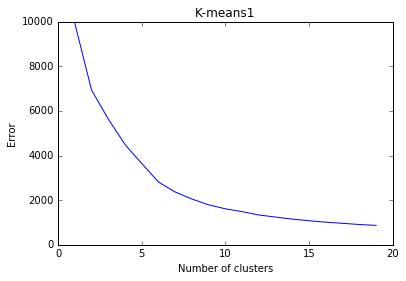

In [54]:
from sklearn.cluster import KMeans
error = np.zeros(20)
for k in range(1,20):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(matrix)
    error[k] = kmeans.inertia_
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.title('K-means1')
dummy = plt.ylabel('Error')

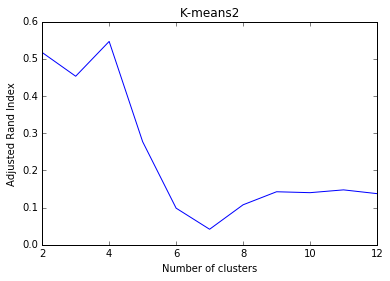

In [57]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    plt.title('K-means2')
sc_evaluate_clusters(matrix,12)

In [59]:
'''
K-Means Method
'''
kmeans = KMeans(init='k-means++', n_clusters= 7, n_init=100)
kmeans.fit_predict(matrix)
centers = kmeans.cluster_centers_

In [60]:
'''
Use this function to get the index of cluster
'''
def Clusts(clustnum,labels_array):
    return np.where(labels_array == clustnum)[0]

In [93]:
'''Use this function to get the labels of clusters'''

def get_labels(ids):
    labels = []
    for i in range(len(ids)):
        price_sum = 0
        for j in range(len(ids[i])):
            price_sum += PProom[ids[i][j]]
        labels.append(price_sum / len(ids[i]))
    return labels

In [94]:
'''Kmeans labels'''
ids_kmeans = []
for i in range(7):
    ids_kmeans.append(Clusts(i,kmeans.labels_))
label_kmeans = get_labels(ids_kmeans)

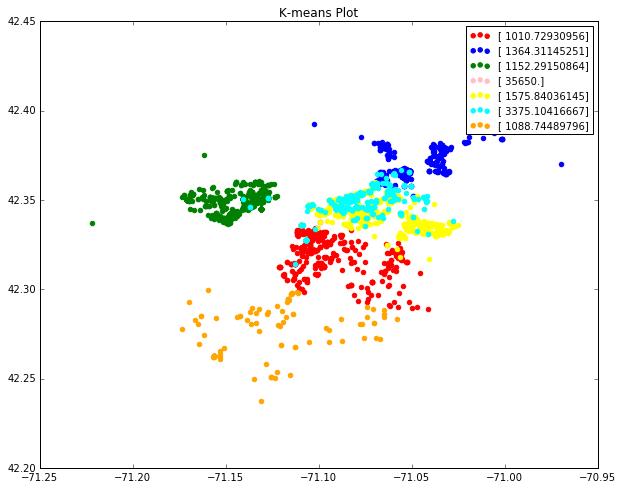

In [142]:
fig = plt.figure(figsize=(10,8))
colors = ['red','blue','green','pink','yellow','cyan','orange'] #'orange','lightblue','lightgreen'],'lightblue','black']
# colors = ['red','white','white','white','white','white','white','white']
for i in range(7):
    indexs = Clusts(i,kmeans.labels_)
    
    x = []
    y = []
    for j in range(len(indexs)):
        x.append(Coordinates[indexs[j],0])
        y.append(Coordinates[indexs[j],1])
    plt.scatter(x, y, color=colors[i],s = 20,label = label_kmeans[i])
# label_color = [colors[l] for l in kmeans.labels_]
# plt.scatter(f_matrix[:,0], f_matrix[:,1],color=label_color)
plt.legend(loc = 'upper right', fontsize = 'medium')
plt.title("K-means Plot")
# for i in range(10):
#     plt.annotate(kmeans_labels[i], xy=(centers[i][0], centers[i][1]),xytext=(centers[i][0]- 2, centers[i][1]))
plt.show()

In [68]:
'''
Hierarchy Method
'''
n_mode = AgglomerativeClustering(linkage = 'ward', n_clusters = 7)
n_mode.fit(matrix)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=7, n_components=None,
            pooling_func=<function mean at 0x1097b7730>)

In [97]:
'''Hierarchy labels'''
ids_h = []
for i in range(7):
    ids_h.append(Clusts(i,n_mode.labels_))
label_hrchy = get_labels(ids_h)

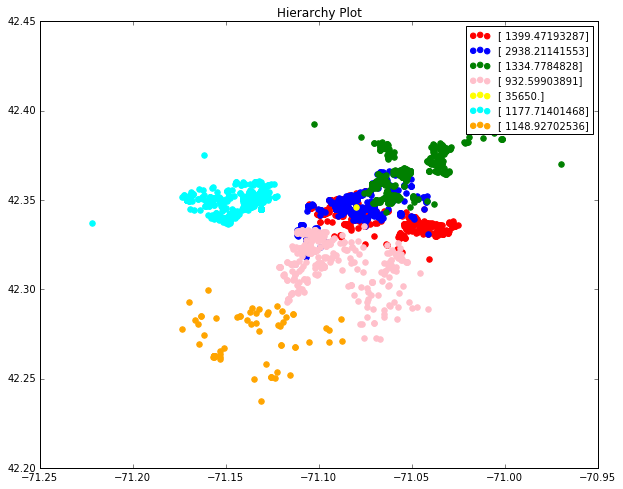

In [141]:
fig = plt.figure(figsize=(10,8))
colors = ['red','blue','green','pink','yellow','cyan','orange']#,'orange','lightblue','lightgreen']
for i in range(7):
    indexs = Clusts(i,n_mode.labels_)
    x = []
    y = []
    for j in range(len(indexs)):
        x.append(Coordinates[indexs[j],0])
        y.append(Coordinates[indexs[j],1])
    plt.scatter(x, y, color=colors[i],s = 30,label = label_hrchy[i])
# label_color = [colors[l] for l in kmeans.labels_]
# plt.scatter(f_matrix[:,0], f_matrix[:,1],color=label_color)
plt.title("Hierarchy Plot")
plt.legend(loc = 'upper right',fontsize = 'medium')

In [89]:
'''
GMM Method
'''
gmm = mixture.GMM(n_components=7, covariance_type='spherical')
gmm.fit(matrix)

GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=7, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [118]:
pro_m= gmm.predict_proba(matrix)
gmm_clusters_dic = {}
for i in range(np.matrix(pro_m).shape[0]):
    mat_list = np.matrix(pro_m)[i,:].tolist()[0]
#     print(type(mat_list))
    a = max(mat_list)
    for j in range(len(mat_list)):
        if a == mat_list[j]:
            max_index = j
    if str(max_index) not in gmm_clusters_dic:
        gmm_clusters_dic[str(max_index)]=[]
        gmm_clusters_dic[str(max_index)].append(i)
    gmm_clusters_dic[str(max_index)].append(i)

In [129]:
'''GMM labels'''
ids_gmm = []
for k,v in gmm_clusters_dic.items():
    
    ids_gmm.append(gmm_clusters_dic[k])
label_gmm = get_labels(ids_gmm)

In [139]:
label_gmm = []
for i in range(len(gmm_clusters_dic)):
    avg = 0
    for j in range(len(gmm_clusters_dic[str(i)])):
        avg+=PProom[gmm_clusters_dic[str(i)][j]]
    label_gmm.append(avg / len(gmm_clusters_dic[str(i)]))

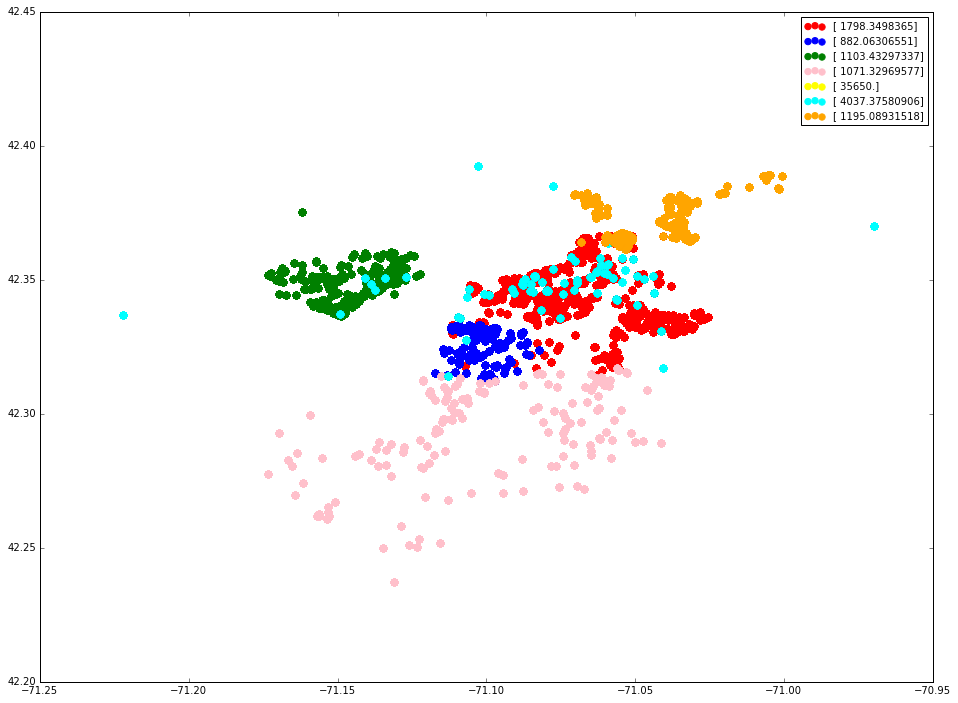

In [140]:
fig = plt.figure(figsize=(16,12))
colors = ['red','blue','green','pink','yellow','cyan','orange']#,'lightblue','lightgreen']
for i in range(7):
    
    x = []
    y = []
    for j in range(len(gmm_clusters_dic[str(i)])):
        x.append(Coordinates[gmm_clusters_dic[str(i)],0])
        y.append(Coordinates[gmm_clusters_dic[str(i)],1])
    plt.scatter(x, y, color=colors[i],s = 40,label = label_gmm[i])
# label_color = [colors[l] for l in kmeans.labels_]
# plt.scatter(f_matrix[:,0], f_matrix[:,1],color=label_color)
plt.legend(loc = 'upper right',fontsize = 'medium')